## Estimating richness using breakaway
## This generates Supplemental Figure 13

In [1]:
# Loading R packages
library(reshape)
library(ggplot2)
library(phyloseq)
library(plyr)
library(dplyr)
library(wesanderson)
library(breakaway)


Attaching package: ‘plyr’

The following objects are masked from ‘package:reshape’:

    rename, round_any


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:reshape’:

    rename

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
# Importing the dataset
ps = readRDS("../../../data/Seq_data/16S/CHTC/Dada2_Results_Full/ps.merged")

## Calculating richness estimates with Betta

In [3]:
FreqTableGenerator = function(Sample){
    df = data.frame(t(otu_table(ps))[,Sample])
    # Grab the OTU table
    colnames(df)="Frequency"
    # Add a column for the frequencies of the OTUs
    df = df %>%
        group_by(Frequency)%>%
        summarize(nOTUs=n())%>%
        arrange(Frequency)
    # Summarize the total OTUs that are present at each frequency
    df = df[df$Frequency>1,]
    # Cut out the 0 and 1 frequencies (because dada2 trimmed singletons)
    colnames(df)=NULL
    # Omit column names
    df = as.matrix(df)
    # Spit out a nice matrix
    df
}
# Generates the frequency table summary needed by breakaway

In [4]:
Samples = sample_names(ps)

In [5]:
# Function to run breakaway on the data
report = data.frame(name="",Richness_estimate="",Richness_stderr="",Richness_model="")
breakawayrunner = function(SampleName){
    df = FreqTableGenerator(SampleName)
    #print(head(df))
    #print(SampleName)
    #print(sum(df[,1]*df[,2]))
    if(df[1,1]==2 & (sum(df[1:6,1])==sum(c(2:7)))){
        # First, check that the first frequency count is, indeed, 2,
        # and there are at least 6 consecutive counts (could actually just do this test)
            m = breakaway_nof1(df, answers=TRUE, plot=FALSE, print=FALSE)
        # Run breakaway for the no singletons data
            Richness_model = m$name
            Richness_estimate = m$est
            Richness_stderr = m$seest
            name = SampleName
        # Grab the outputs
            report = data.frame(name,Richness_estimate,Richness_stderr,Richness_model)
        # Generate a report
    } else {
        name = SampleName
        report=data.frame(name)
        # If breakaway isn't going to work anyway, just spit out the name (and NAs)
        }

    report

}

In [6]:
# Running breakaway
Reports = mdply(Samples,breakawayrunner)
head(Reports)

X1,name,Richness_estimate,Richness_stderr,Richness_model
1,15S-NT-19O,1056.9100,3.140691,WLRM
2,15S-NT-20O,760.6622,13402.029645,model_1_1
3,15S-NT-21M,605.1859,2.159701,WLRM
4,15S-NT-21O,592.3375,5.801976,model_1_1
5,15S-NT-22M,412.3188,3.121177,WLRM
6,15S-NT-22O,460.4217,3.822670,WLRM


In [7]:
Report_Summary = Reports %>%
    group_by(Richness_model)%>%
    summarize(n())
Report_Summary
# How many of each sample fit each model type

Richness_model,n()
WLRM,70
model_1_1,26
model_2_1,2
model_2_2,3
model_1_0,1


In [8]:
# Add richness estimates and standard error to the sample dataframe
sample_data(ps)[,colnames(Reports)[3:5]]=Reports[,3:5]

In [9]:
# Grabbing the sample data
d = sample_data(ps)

In [10]:
# Setting up function to propagate errors from richness estimates
BettaRunner = function(Veg_Comm){
    d = d[d$Veg_Comm==Veg_Comm,]
    CoVars = data.frame(Veg_Comm=d$Veg_Comm,Severity_Class=d$Severity_Class)
    CoVars$Severity=c(rep("",dim(CoVars)[1]))
    SeverityOptions = levels(CoVars$Severity_Class)
    N = length(SeverityOptions)
    for (i in 1:dim(CoVars)[1]){
        Severity_Class = paste(CoVars$Severity_Class[i])    
        if("Unburned" %in% SeverityOptions){CoVars$Unburned[i] = ifelse(Severity_Class=="Unburned",1,0)}
        if("Low" %in% SeverityOptions){CoVars$Low[i] = ifelse(Severity_Class=="Low",1,0)}
        if("Moderate" %in% SeverityOptions){CoVars$Moderate[i] = ifelse(Severity_Class=="Moderate",1,0)}
        if("High" %in% SeverityOptions){CoVars$High[i] = ifelse(Severity_Class=="High",1,0)}
    }
    nmax = 3+N
    CoVars = as.matrix(CoVars[,4:nmax])
    Richness_estimates = as.vector(d$Richness_estimate)
    Richness_stderr = as.vector(d$Richness_stderr)
    BettaEst = betta(Richness_estimates,Richness_stderr,CoVars)
    X = data.frame(BettaEst$table)
    X$Veg_Comm = Veg_Comm
    return(X)
}

In [12]:
# Which vegetation communities we will apply the function to (all of them)
Veg_Comms = levels(d$Veg_Comm)

In [13]:
# Run the function on all veg comms
x = lapply(Veg_Comms,FUN=BettaRunner)

In [14]:
# Extract results
x[[1]]$Severity_Class=row.names(x[[1]])
x[[2]]$Severity_Class=row.names(x[[2]])
x[[3]]$Severity_Class=row.names(x[[3]])
x[[4]]$Severity_Class=row.names(x[[4]])
x[[5]]$Severity_Class=row.names(x[[5]])

In [15]:
# Join into dataframe and adjust errors
x = rbind(x[[1]],x[[2]],x[[3]],x[[4]],x[[5]])
x = data.frame(x)
x$p.adj = p.adjust(x$p.values, method = "bonferroni")
x$Ymin = x$Estimates-1.96*x$Standard.Errors
x$Ymax = x$Estimates+1.96*x$Standard.Errors
x$comb = paste(x$Veg_Comm,x$Severity_Class)
x

,Estimates,Standard.Errors,p.values,Veg_Comm,Severity_Class,p.adj,Ymin,Ymax,comb
Unburned,823.9007,166.62754,0.000,Black Spruce,Unburned,0.000,497.31074,1150.4907,Black Spruce Unburned
Low,453.0002,331.93204,0.172,Black Spruce,Low,1.000,-197.58660,1103.5870,Black Spruce Low
Moderate,503.7315,166.60217,0.002,Black Spruce,Moderate,0.036,177.19121,830.2717,Black Spruce Moderate
High,558.9999,137.03029,0.000,Black Spruce,High,0.000,290.42055,827.5793,Black Spruce High
Unburned1,406.2574,182.02308,0.026,Jack Pine,Unburned,0.468,49.49219,763.0227,Jack Pine Unburned
Low1,831.9221,157.80834,0.000,Jack Pine,Low,0.000,522.61778,1141.2265,Jack Pine Low
Moderate1,511.8565,111.59284,0.000,Jack Pine,Moderate,0.000,293.13453,730.5785,Jack Pine Moderate
High1,501.4017,81.53408,0.000,Jack Pine,High,0.000,341.59486,661.2085,Jack Pine High
Unburned2,595.8814,106.86980,0.000,Mixedwood,Unburned,0.000,386.41657,805.3462,Mixedwood Unburned
Low2,554.3953,99.03011,0.000,Mixedwood,Low,0.000,360.29623,748.4943,Mixedwood Low


In [16]:
# Setting factors
x$Severity_Class=factor(x$Severity_Class,levels=c("Unburned","Low","Moderate","High"))
x$Veg_Comm = factor(x$Veg_Comm, levels=c("Black Spruce", "Jack Pine", "Mixedwood", "Treed Wetland", "Open Wetland"))

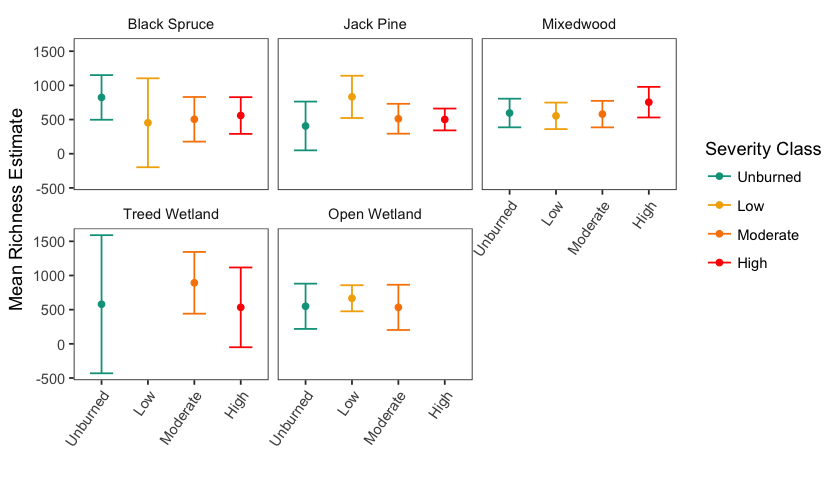

In [18]:
# Plotting the data

options(repr.plot.width=7, repr.plot.height=4)
p = ggplot(x)
p = p + geom_errorbar(aes(x=Severity_Class,min = Ymax, max = Ymin,color=Severity_Class),width=0.5)
p = p + geom_point(aes(x=Severity_Class,y=Estimates,color=Severity_Class))
p = p + facet_wrap(~Veg_Comm)
#p = p + ylim(0,2000)
palette = wes_palette("Darjeeling")[c(2,3,4,1,5)]
p = p + scale_colour_manual(values=palette)
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
   ,strip.background = element_rect(colour="white", fill="white"))
p = p + theme(axis.text.x = element_text(angle=55,hjust=1))
p = p + ylab("Mean Richness Estimate")
p = p + xlab("")
p = p + guides(colour=guide_legend(title="Severity Class"))
p